In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from networkx.readwrite import json_graph
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from IPython.core.display import display, HTML
from string import Template
import json, random

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### GTC_Functions

In [2]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# data importing
raw_data = pd.read_csv('data/clean_data.csv')

class Graph_GT:
    def __init__(self, year, raw_data = raw_data):
        """
        Initialization
        self.df is a pd.dataframe for the given year
        """

        self.year = year
        self.df = raw_data.loc[raw_data['Yr']==year]
 

    def country_list(self):
        """
        raw_date should be a pd.dataframe
        
        """
        country_list = set(list(self.df.Reporting_Entity_RIC_Name)\
                           +list(self.df.Partner_Entity_RIC_Name))
        country_list = sorted(list(country_list))
        return country_list
    
    
    def graph(self):
        """
        creat a nx.graph object(weighted & directed)
        of the trading data for the given year
        """
        
        list_trade = self.df.values
        list_trade_nanremoved = []
        for row in list_trade:
            if np.isnan(row[3]) == False:
                list_trade_nanremoved +=  [row]
        list_trade = np.array(list_trade_nanremoved)

        #min_max_scaler = preprocessing.MinMaxScaler()
        #
        #list_trade[:,2] = min_max_scaler.fit_transform(list_trade[:,2])       
        #list_trade[:,2] = preprocessing.scale(list_trade[:,2])

        G = nx.Graph()
        nodes = []
        for row in list_trade:
            #if (row[3]=="Country")*(row[6]=="Country")==1:
            #if np.isnan(row[2])==False:
            #G.add_edge(row[0],row[1],weight = np.exp(-0.5*row[2]**2))
                #G.add_edge(row[0],row[1],weight = row[2])
                G.add_edge(row[1],row[2])
                nodes.append(row[1])
                nodes.append(row[2])
        nodes = set(nodes)
        G.add_nodes_from(nodes)
        return G
    
    def node_link_data(self):
        """
        creat a nx.graph object(weighted & directed)
        of the trading data for the given year
        """
        
        list_trade = self.df.values
#         list_trade_nanremoved = []
#         for row in list_trade:
#             if np.isnan(row[3]) == False:
#                 list_trade_nanremoved +=  [row]
#         list_trade = np.array(list_trade_nanremoved)

        #min_max_scaler = preprocessing.MinMaxScaler()
        #
        #list_trade[:,2] = min_max_scaler.fit_transform(list_trade[:,2])       
        #list_trade[:,2] = preprocessing.scale(list_trade[:,2])
        data = {"nodes": [], "edges": []}
        for row in list_trade:
#             if (row[3]=="Country")*(row[6]=="Country")==1:
            data["edges"].append({
                "source":row[1],
                "target":row[2],
                "flow":row[3]
                })
            # nodes.append(row[0])
            # nodes.append(row[1])
            data["nodes"].append({
                "id":row[1],
                "label":row[1],
                "continent":row[4],
                "type":row[5]
            })
            data["nodes"].append({
                "id":row[2],
                "label":row[2],
                "continent":row[6],
                "type":row[7]
                })
        data["nodes"]=[dict(t) for t in set([tuple(d.items()) for d in data["nodes"]])]
        return data
    


In [3]:
GT1920 = Graph_GT(year = 1860)

In [4]:
gra = GT1920.graph()

In [5]:
json_graph=GT1920.node_link_data()

## Louvain Methode

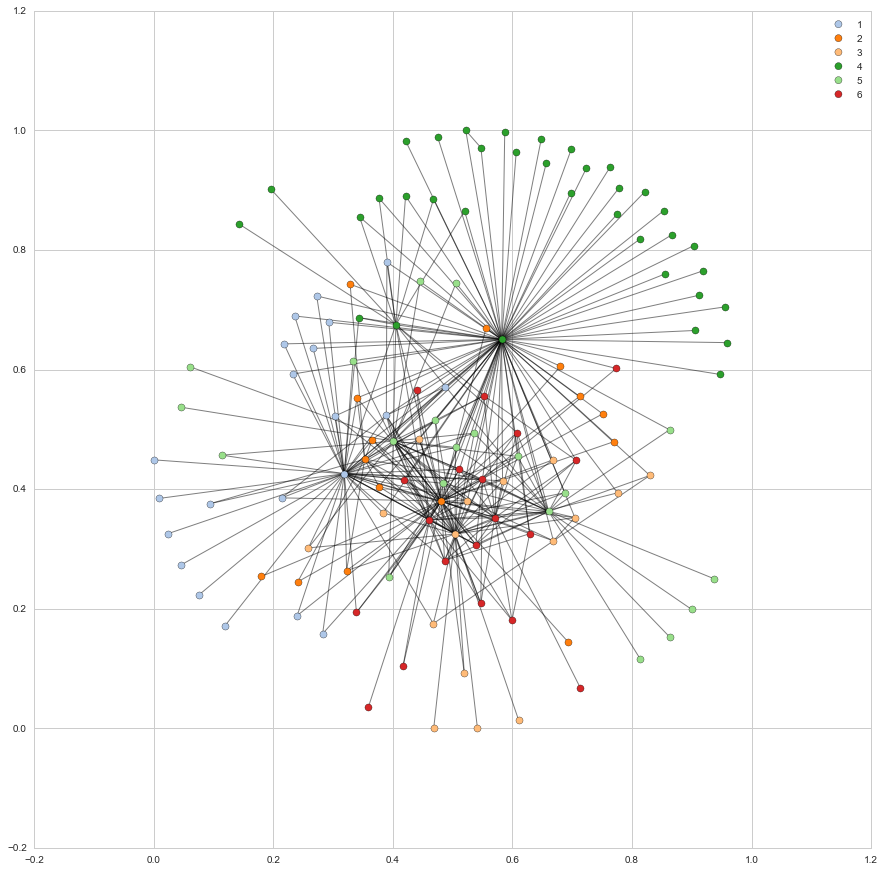

In [9]:
import community_louvain

plt.figure(figsize = [15,15])
#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = gra

#first compute the best partition
partition = community_louvain.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
          ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
          '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']

for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()


In [7]:
for node in json_graph["nodes"]:
    node["community"]=partition[node["id"]]
    node["color"]=colors[partition[node["id"]]]
    node["x"]= pos[node["id"]][0]
    node["y"]= pos[node["id"]][1]
    node["size"]= random.uniform(0.2,1)

In [15]:
for i in range(len(json_graph["edges"])):
    json_graph["edges"][i]["id"]="e"+str(i)

In [13]:
HTML('''
<script src="lib/sigmajs/sigma.min.js"></script>
<script src="js/sigma-add-method-neighbors.js"></script>
<script src="lib/sigmajs/plugins/sigma.layout.forceAtlas2.min.js"></script>
''')

In [10]:
js_text_template = Template(open('js/sigma-graph.js','r').read())

js_text = js_text_template.substitute({'graph_data': json.dumps(json_graph),
                                       'container': 'graph-div'})

html_template = Template('''
<div id="graph-div" style="height:400px"></div>
<script> $js_text </script>
''')
HTML(html_template.substitute({'js_text': js_text}))

## Spectral Clustering

In [47]:
Lap_nom = nx.normalized_laplacian_matrix(G).todense()

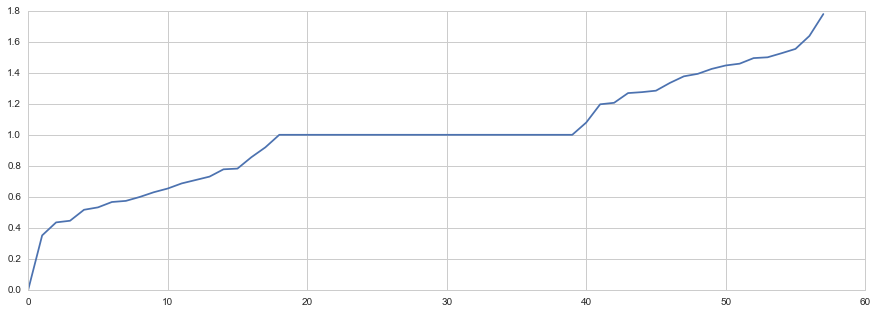

In [48]:
plt.figure(figsize = [15,5])
eig_val, eig_vec = np.linalg.eig(Lap_nom)
plt.plot(sorted(np.linalg.eig(Lap_nom)[0][0:58]))

In [49]:
k = 12
selected_vec = np.zeros([len(eig_val),k])
thr = sorted(eig_val)[k-1]
eig_val, eig_vec = np.linalg.eig(Lap_nom)
ind = 0
for i in range(len(eig_val)):
    if eig_val[i]<=thr:
        selected_vec[:,ind] = np.array(eig_vec)[:,i]
        ind += 1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


In [50]:
X = selected_vec

In [51]:
cluster_km = KMeans(n_clusters = 10,max_iter = 10000,tol = 0.00000001)
features_spectre = X
cluster_km.fit(features_spectre)
pred = cluster_km.predict(X)

dict_predict = {}
for i in range(len(G.nodes())):
    dict_predict.update(
    {
            G.nodes()[i] : int(pred[i])
        })

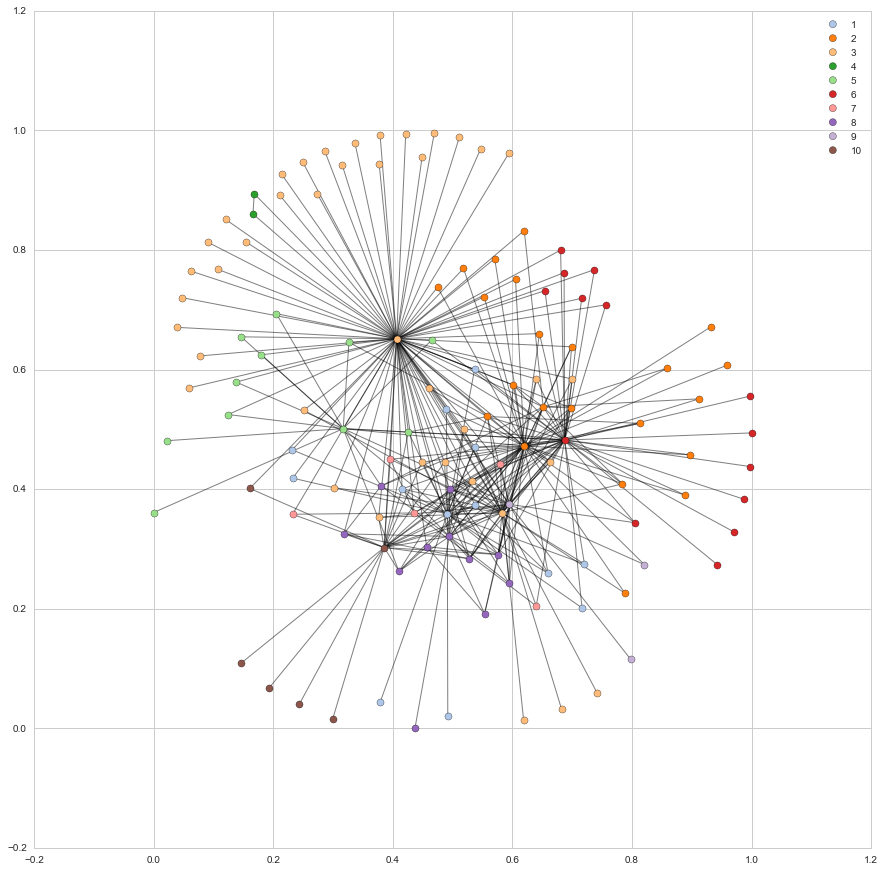

In [52]:
plt.figure(figsize = [15,15])
count = 0
for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()

In [19]:
for node in json_graph["nodes"]:
    node["community"]=dict_predict[node["id"]]
    node["color"]=colors[dict_predict[node["id"]]]
    node["x"]= pos[node["id"]][0]
    node["y"]= pos[node["id"]][1]
    node["size"]= random.uniform(0.2,1)

In [16]:
js_text_template = Template(open('js/sigma-graph.js','r').read())

js_text2 = js_text_template.substitute({'graph_data': json.dumps(json_graph),
                                       'container': 'graph-div2'})

html_template = Template('''
<div id="graph-div2" style="height:400px"></div>
<script> $js_text </script>
''')
HTML(html_template.substitute({'js_text': js_text2}))

## Girvan-Newman Clustering

In [6]:
import centrality
import itertools
G = gra

In [7]:
k = 4
comp = centrality.girvan_newman(G)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)
ls=[]
depth=0
dict_predict = {}
for communities in limited:
#     ls += [list(sorted(c) for c in communities)]
#     print(list(sorted(c) for c in communities))
    depth+=1
    if depth==k-1:
        for i in range(len(communities)):
            for d in communities[i]:
                dict_predict.update({
                        d:i
                    })
print dict_predict
                
                

{'Canada': 0, 'Brazil': 0, 'Russia/USSR': 0, 'Tetuan': 0, 'Guyana (Br. Guiana)': 1, 'Buenos Aires': 1, 'Bremen': 0, 'Morocco': 1, 'Cape Verde': 1, 'Norway': 0, 'Gibraltar': 0, 'Ireland': 0, 'Republic of St. Mark': 0, 'Argentina': 0, 'Bolivia': 0, 'Aden': 2, 'Ecuador': 0, 'Suez Canal Zone': 2, 'Australia': 0, 'Martinique': 1, 'Iran (Persia)': 0, 'Madeira Isles': 1, 'St. Barthelemy': 0, 'Victoria': 1, 'Italy': 0, 'Guatemala': 0, 'Natal': 1, 'Ghana (Gold Coast)': 1, 'Chile': 0, 'Hamburg': 0, 'Netherlands Antilles': 0, 'Labuan I.': 1, 'Haiti': 0, 'Hong Kong': 1, 'Sierra Leone': 1, 'Spain': 0, 'Queensland': 1, 'Netherlands': 0, 'French Guyana': 0, 'Sri Lanka (Ceylon)': 2, 'Denmark': 0, 'Philippines': 0, 'Puerto Rico': 0, 'Canary Is.': 1, 'Dominican Republic (Santo Domingo)': 0, 'Belgium': 0, 'Andaman and Nicobar Is.': 1, 'Cape Colony': 2, 'Switzerland': 0, 'New Zealand': 1, 'Thailand (Siam)': 2, 'New Brunswick': 1, 'South Australia': 1, 'Moldavia': 0, 'Western Australia': 1, 'Papal States':

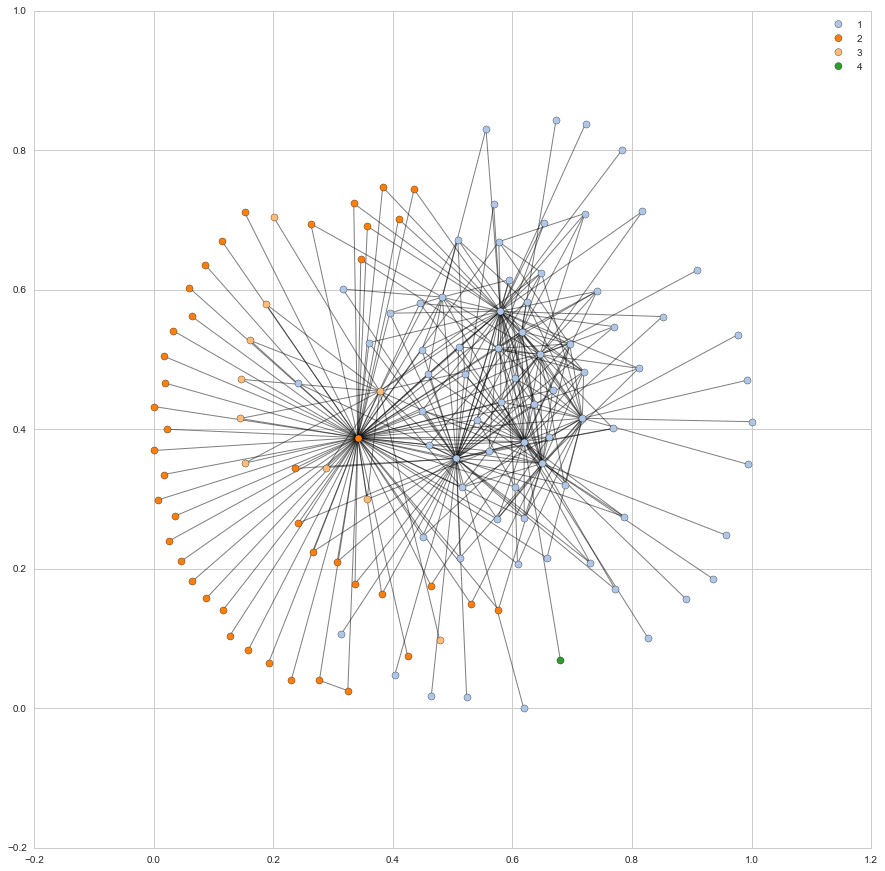

In [10]:
plt.figure(figsize = [15,15])
count = 0
pos = nx.fruchterman_reingold_layout(G)

for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()

In [11]:
for node in json_graph["nodes"]:
    node["community"]=dict_predict[node["id"]]
    node["color"]=colors[dict_predict[node["id"]]]
    node["x"]= pos[node["id"]][0]
    node["y"]= pos[node["id"]][1]
    node["size"]= random.uniform(0.2,1)

In [14]:
js_text_template = Template(open('js/sigma-graph.js','r').read())

js_text3 = js_text_template.substitute({'graph_data': json.dumps(json_graph),
                                       'container': 'graph-div2'})

html_template = Template('''
<div id="graph-div3" style="height:400px"></div>
<script> $js_text </script>
''')
HTML(html_template.substitute({'js_text': js_text3}))

In [33]:
 def generate_list_name(ls):
    '''
    name of the nodes(parents & children)
    depth: x
    location: y
    the name will be like x:y
    ''' 
    list_name = [[[] for j in range(len(ls[i]))] for i in range(len(ls))]
    for depth in range(len(ls)):
        for location in range(len(ls[depth])):
            list_name[depth][location] = str(depth)+':'+str(location)
    return list_name

In [67]:
ls_name = generate_list_name(ls)
ls_name

[['0:0', '0:1'], ['1:0', '1:1', '1:2'], ['2:0', '2:1', '2:2', '2:3']]

In [68]:
def get_dendrogram_list(ls):
    list_dendro = []
    for depth in range(len(ls)-1):
        for location in range(len(ls[depth])):
            for location_next in range(len(ls[depth+1])):
                if set(ls[depth+1][location_next]).issubset(set(ls[depth][location])):
                    list_dendro += [{'source':str(depth)+':'+str(location),\
                    'target':str(depth+1)+':'+str(location_next)}]
    return list_dendro
                    

In [69]:
list_dendro = get_dendrogram_list(ls)
list_dendro

[{'source': '0:0', 'target': '1:0'},
 {'source': '0:0', 'target': '1:1'},
 {'source': '0:1', 'target': '1:2'},
 {'source': '1:0', 'target': '2:0'},
 {'source': '1:0', 'target': '2:1'},
 {'source': '1:1', 'target': '2:2'},
 {'source': '1:2', 'target': '2:3'}]

In [70]:
def get_nodes_from_name(ele_list_name,ls):
    depth,location =ele_list_name.split(':')
    return ls[int(depth)][int(location)]
    

In [71]:
get_nodes_from_name('1:1',ls)

['Italy']